Total runs with amp=True: 60
Total runs with amp=False: 60


/home/woody/iwai/iwai128h/software/private/conda/envs/draem/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/home/woody/iwai/iwai128h/software/private/conda/envs/draem/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/home/woody/iwai/iwai128h/software/private/conda/envs/draem/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_ou

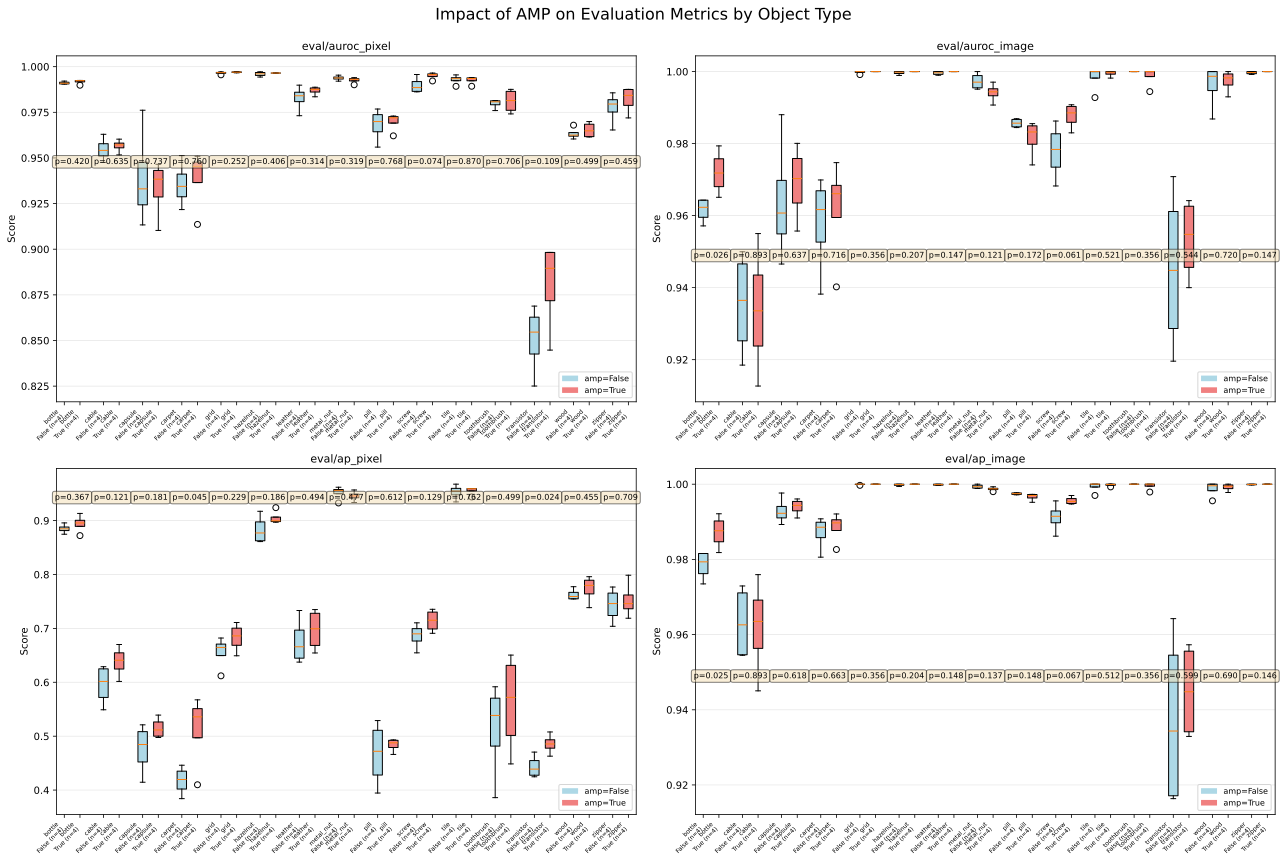

/tmp/ipykernel_3524422/993428091.py:179: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_plot, labels=labels, patch_artist=True, widths=0.6)
/tmp/ipykernel_3524422/993428091.py:179: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_plot, labels=labels, patch_artist=True, widths=0.6)
/tmp/ipykernel_3524422/993428091.py:179: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_plot, labels=labels, patch_artist=True, widths=0.6)
/tmp/ipykernel_3524422/993428091.py:179: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since M

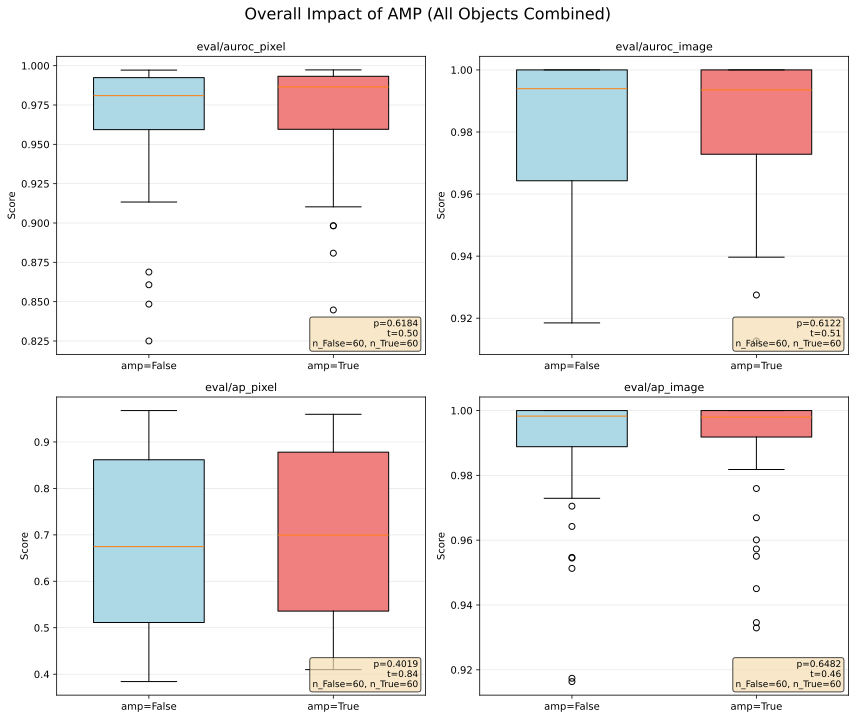

eval/auroc_pixel: r=0.0459, p=0.6184
eval/auroc_image: r=0.0467, p=0.6122
eval/ap_pixel: r=0.0772, p=0.4019
eval/ap_image: r=0.0421, p=0.6482


In [1]:
import wandb
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

# Enable high-quality vector graphics output
%config InlineBackend.figure_formats = ['svg']

runs = wandb.Api().runs("team-cr/DRAEM_seminar_AD")

# Extract data from runs
data = []
for run in runs:
    if 'amp' in run.config and run.summary and 'new_baseline' in run.tags and run.state == 'finished':
        record = {
            'amp': run.config['amp'],
            'obj_name': run.config.get('obj_name', 'unknown')
        }
        # Extract eval metrics from summary
        for key in run.summary.keys():
            if key.startswith('eval/'):
                record[key] = run.summary[key]
        if len(record) > 2:  # Only add if we have eval metrics
            data.append(record)

df_analysis = pd.DataFrame(data)


amp_true_all = df_analysis[df_analysis['amp'] == True]
amp_false_all = df_analysis[df_analysis['amp'] == False]

print(f"Total runs with amp=True: {len(amp_true_all)}")
print(f"Total runs with amp=False: {len(amp_false_all)}")

eval_metrics = [col for col in df_analysis.columns if col.startswith('eval/')]

for metric in eval_metrics:
    if metric in amp_true_all.columns and metric in amp_false_all.columns:
        true_vals = amp_true_all[metric].dropna()
        false_vals = amp_false_all[metric].dropna()
        
        if len(true_vals) > 0 and len(false_vals) > 0:
            # Calculate statistics
            t_stat, p_value = stats.ttest_ind(true_vals, false_vals, nan_policy='omit')
            
            # Calculate correlation (point-biserial correlation between binary amp and metric)
            amp_numeric = df_analysis['amp'].astype(int)
            valid_idx = df_analysis[metric].notna()
            if valid_idx.sum() > 1:
                corr, corr_p = stats.pointbiserialr(amp_numeric[valid_idx], df_analysis[metric][valid_idx])
            else:
                corr, corr_p = np.nan, np.nan
            
            # Calculate effect size (Cohen's d)
            pooled_std = np.sqrt(((len(true_vals)-1)*true_vals.std()**2 + (len(false_vals)-1)*false_vals.std()**2) / (len(true_vals)+len(false_vals)-2))
            cohens_d = (true_vals.mean() - false_vals.mean()) / pooled_std if pooled_std > 0 else 0
            

# Analyze by object name
for obj_name in sorted(df_analysis['obj_name'].unique()):
    df_obj = df_analysis[df_analysis['obj_name'] == obj_name]
    amp_true = df_obj[df_obj['amp'] == True]
    amp_false = df_obj[df_obj['amp'] == False]
    
    # Analyze each eval metric
    eval_metrics = [col for col in df_obj.columns if col.startswith('eval/')]
    
    for metric in eval_metrics:
        if metric in amp_true.columns and metric in amp_false.columns:
            true_vals = amp_true[metric].dropna()
            false_vals = amp_false[metric].dropna()
            
            if len(true_vals) > 0 and len(false_vals) > 0:
                # Calculate statistics
                t_stat, p_value = stats.ttest_ind(true_vals, false_vals, nan_policy='omit')
                
                # Calculate correlation (point-biserial correlation between binary amp and metric)
                amp_numeric = df_obj['amp'].astype(int)
                valid_idx = df_obj[metric].notna()
                if valid_idx.sum() > 1:
                    corr, corr_p = stats.pointbiserialr(amp_numeric[valid_idx], df_obj[metric][valid_idx])
                else:
                    corr, corr_p = np.nan, np.nan
                

# Create visualization by object
obj_names = sorted(df_analysis['obj_name'].unique())
metrics_to_plot = ['eval/auroc_pixel', 'eval/auroc_image', 'eval/ap_pixel', 'eval/ap_image']

# Create a figure with subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Impact of AMP on Evaluation Metrics by Object Type', fontsize=16, y=0.995)

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Prepare data for grouped box plot
    positions = []
    data_plot = []
    labels = []
    colors = []
    
    pos = 0
    for obj_idx, obj_name in enumerate(obj_names):
        df_obj = df_analysis[df_analysis['obj_name'] == obj_name]
        
        if metric in df_obj.columns:
            amp_false_vals = df_obj[df_obj['amp'] == False][metric].dropna()
            amp_true_vals = df_obj[df_obj['amp'] == True][metric].dropna()
            
            if len(amp_false_vals) > 0:
                positions.append(pos)
                data_plot.append(amp_false_vals)
                labels.append(f'{obj_name}\nFalse (n={len(amp_false_vals)})')
                colors.append('lightblue')
                pos += 1
            
            if len(amp_true_vals) > 0:
                positions.append(pos)
                data_plot.append(amp_true_vals)
                labels.append(f'{obj_name}\nTrue (n={len(amp_true_vals)})')
                colors.append('lightcoral')
                pos += 1
            
            # Calculate and display correlation for this object
            amp_numeric = df_obj['amp'].astype(int)
            valid_idx = df_obj[metric].notna()
            if valid_idx.sum() > 1:
                corr, corr_p = stats.pointbiserialr(amp_numeric[valid_idx], df_obj[metric][valid_idx])
                
                # Add p-value text to the plot
                text_pos = (positions[-2] + positions[-1]) / 2 if len(positions) >= 2 else positions[-1]
                y_pos = ax.get_ylim()[1] if ax.get_ylim()[1] > 0 else 1.0
                ax.text(text_pos, y_pos * 0.95, f'p={corr_p:.3f}', 
                       ha='center', va='top', fontsize=8, 
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            pos += 0.5  # Add spacing between objects
    
    # Create box plot
    bp = ax.boxplot(data_plot, positions=positions, widths=0.6, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=6)
    ax.set_ylabel('Score', fontsize=10)
    ax.set_title(metric, fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightblue', label='amp=False'),
                      Patch(facecolor='lightcoral', label='amp=True')]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

# Create overall comparison plot (not differentiated by object)
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10))
fig2.suptitle('Overall Impact of AMP (All Objects Combined)', fontsize=16, y=0.995)

for idx, metric in enumerate(metrics_to_plot):
    if metric in df_analysis.columns:
        ax = axes2[idx // 2, idx % 2]
        
        amp_false_vals = df_analysis[df_analysis['amp'] == False][metric].dropna()
        amp_true_vals = df_analysis[df_analysis['amp'] == True][metric].dropna()
        
        data_plot = [amp_false_vals, amp_true_vals]
        labels = ['amp=False', 'amp=True']
        
        bp = ax.boxplot(data_plot, labels=labels, patch_artist=True, widths=0.6)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][1].set_facecolor('lightcoral')
        
        # Calculate and display statistics
        amp_numeric = df_analysis['amp'].astype(int)
        valid_idx = df_analysis[metric].notna()
        if valid_idx.sum() > 1:
            corr, corr_p = stats.pointbiserialr(amp_numeric[valid_idx], df_analysis[metric][valid_idx])
            t_stat, p_value = stats.ttest_ind(amp_true_vals, amp_false_vals, nan_policy='omit')
            
            # Add statistics text
            stats_text = f'p={corr_p:.4f}\nt={t_stat:.2f}\nn_False={len(amp_false_vals)}, n_True={len(amp_true_vals)}'
            ax.text(0.98, 0.02, stats_text, transform=ax.transAxes,
                   ha='right', va='bottom', fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
        
        ax.set_ylabel('Score', fontsize=10)
        ax.set_title(metric, fontsize=11)
        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

for metric in metrics_to_plot:
    if metric in df_analysis.columns:
        amp_numeric = df_analysis['amp'].astype(int)
        valid_idx = df_analysis[metric].notna()
        if valid_idx.sum() > 1:
            corr, corr_p = stats.pointbiserialr(amp_numeric[valid_idx], df_analysis[metric][valid_idx])
            print(f"{metric}: r={corr:.4f}, p={corr_p:.4f}")